In [15]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './img/train'
categories = ['Cat', 'Dog']
np_classes = len(categories)

image_w = 64
image_h = 64


pixel = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.*.jpg")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/binary_image_data.npy", xy)

    

Cat  :  ./img/train/Cat\cat.0.jpg
Cat  :  ./img/train/Cat\cat.1268.jpg
Cat  :  ./img/train/Cat\cat.1538.jpg
Cat  :  ./img/train/Cat\cat.1808.jpg
Cat  :  ./img/train/Cat\cat.2078.jpg
Cat  :  ./img/train/Cat\cat.2348.jpg
Cat  :  ./img/train/Cat\cat.2618.jpg
Cat  :  ./img/train/Cat\cat.2889.jpg
Cat  :  ./img/train/Cat\cat.3158.jpg
Cat  :  ./img/train/Cat\cat.3428.jpg
Cat  :  ./img/train/Cat\cat.3699.jpg
Cat  :  ./img/train/Cat\cat.3969.jpg
Cat  :  ./img/train/Cat\cat.4238.jpg
Cat  :  ./img/train/Cat\cat.4508.jpg
Cat  :  ./img/train/Cat\cat.4779.jpg
Cat  :  ./img/train/Cat\cat.5048.jpg
Cat  :  ./img/train/Cat\cat.5318.jpg
Cat  :  ./img/train/Cat\cat.5589.jpg
Cat  :  ./img/train/Cat\cat.5859.jpg
Cat  :  ./img/train/Cat\cat.6128.jpg
Cat  :  ./img/train/Cat\cat.6399.jpg
Cat  :  ./img/train/Cat\cat.6669.jpg
Cat  :  ./img/train/Cat\cat.6939.jpg
Cat  :  ./img/train/Cat\cat.7208.jpg
Cat  :  ./img/train/Cat\cat.7479.jpg
Cat  :  ./img/train/Cat\cat.7749.jpg
Cat  :  ./img/train/Cat\cat.8018.jpg
Cat 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(22500, 64, 64, 3)
22500
[11293 11207]
[1207 1293]


In [4]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_dir = './model'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/dog_cat_classify.model"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)         

In [6]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])


Train on 19125 samples, validate on 3375 samples
Epoch 1/100
19125/19125 [==============================] - 90s 5ms/step - loss: 0.6467 - accuracy: 0.6175 - val_loss: 0.5700 - val_accuracy: 0.7025

Epoch 00001: val_loss improved from inf to 0.57001, saving model to ./model/dog_cat_classify.model
Epoch 2/100
19125/19125 [==============================] - 87s 5ms/step - loss: 0.5448 - accuracy: 0.7266 - val_loss: 0.5304 - val_accuracy: 0.7313

Epoch 00002: val_loss improved from 0.57001 to 0.53036, saving model to ./model/dog_cat_classify.model
Epoch 3/100
19125/19125 [==============================] - 82s 4ms/step - loss: 0.4739 - accuracy: 0.7743 - val_loss: 0.4603 - val_accuracy: 0.7787

Epoch 00003: val_loss improved from 0.53036 to 0.46025, saving model to ./model/dog_cat_classify.model
Epoch 4/100
19125/19125 [==============================] - 86s 4ms/step - loss: 0.4264 - accuracy: 0.8064 - val_loss: 0.4122 - val_accuracy: 0.8095

Epoch 00004: val_loss improved from 0.46025 to 0.

In [7]:
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

2500/2500 [==============================] - 3s 1ms/step
정확도 : 0.88 


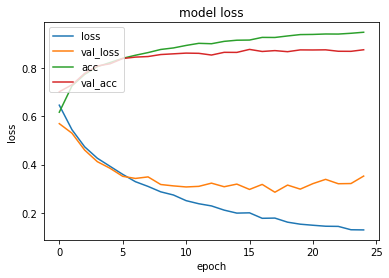

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

In [22]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

import tensorflow as tf

seed = 5
tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './img/validation'


image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)


X = np.array(X)
X = X.astype(float) / 255
model = load_model('./model/dog_cat_classify.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0
for i in prediction:
    if i >= 0.5: print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는 개 로 추정됩니다.")
    else : print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는 고양이 으로 추정됩니다.")
    cnt += 1

해당 catlil1.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil10.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil11.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil12.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil13.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil14.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil15.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil16.jpg  이미지는 개 로 추정됩니다.
해당 catlil17.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil18.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil19.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil2.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil20.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil21.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil22.JPG  이미지는 고양이 으로 추정됩니다.
해당 catlil23.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil24.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil25.jpg  이미지는 개 로 추정됩니다.
해당 catlil26.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil27.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil28.jpg  이미지는 개 로 추정됩니다.
해당 catlil29.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil3.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil30.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil31.jpg  이미지는 개 로 추정됩니다.
해당 catlil32.jpg  이미지는 개 로 추정됩니다.
해당 catlil33.jpg  이미지는 개 로 추정됩니다.
해당 catlil34.jpg  이미지는 고양이 으로 추정됩니다.
해당 catlil35.j